In [1]:
# %pip install python-mnist
# %pip install matplotlib

import os
import math
import random
from mnist import MNIST
import matplotlib.pyplot as plt
from collections import defaultdict

import pickle
import time

%matplotlib inline

In [2]:
mndata = MNIST('dataset')

x_train, y_train = mndata.load_training()

In [34]:
def flatten(array):
    flat = []

    for item in array:
        try:
            iter(item)
            flat.extend(flatten(item))
        except:
            flat.append(item)

    return flat

def reshape(array, rows, cols):
    flat_array = flatten(array)

    if rows * cols != len(flat_array):
        raise Exception(f"Can't reshape array to ({rows}, {cols})")

    reshaped = [[0] * cols for _ in range(rows)]    

    for row in range(rows):
        for col in range(cols):
            reshaped[row][col] = flat_array[row * cols + col]

    return reshaped


def argmax(values):
    max_value = float('-inf')
    max_index = 0

    for idx, value in enumerate(values):
        if value > max_value:
            max_index = idx
            max_value = value

    return max_index

def prepare(image):
    image = reshape(image, 28, 28)

    output = []
    
    # major diagonal
    for i in range(28):
        output.append(image[i][i] / 255)
    
    # minor diagonal
    for i in range(28):
        output.append(image[27 - i][i] / 255)
    
    # center horizontal ( 3 pixels)
    for j in range(13, 16):
        for i in range(28):        
            output.append(image[j][i] / 255)

    # center vertical    ( 3 pixels) 
    for j in range(13, 16):
        for i in range(28):        
            output.append(image[i][j] / 255)


    return output    

In [11]:
# Normalize input
x_train_normalized = []

for image in x_train:
    x_train_normalized.append(prepare(image))    

### Naive Bayes

In [12]:
# count frequecy of each number in the dataset

class_frequency = {i:0 for i in range(10)}

for label in y_train:
    class_frequency[label] += 1

In [13]:
# calculate prior

prior = {}

dataset_size = len(y_train)

for class_ in range(10):
    prior[class_] = class_frequency[class_] / dataset_size


In [24]:
# calculate mean and variance for each pixels

features = len(x_train_normalized[0])

mean = defaultdict(lambda : [0] * features)

for image, label in zip(x_train_normalized, y_train):
    for pixel_idx, pixel in enumerate(image):
        mean[label][pixel_idx] += pixel

        
for value in mean.values():
    for idx in range(len(value)):
        value[idx] /= dataset_size

In [29]:
# varience

varience = defaultdict(lambda : [0] * features)

for image, label in zip(x_train_normalized, y_train):
    for pixel_idx, pixel in enumerate(image):
        varience[label][pixel_idx] += (pixel - mean[label][pixel_idx]) ** 2

        
for value in varience.values():
    for idx in range(len(value)):
        value[idx] /= dataset_size                        

In [30]:
def gausian_probability(xs, mean, var, smoothing):
    probability = []
        
    for idx, x in enumerate(xs):
        m = mean[idx]
        v = var[idx] + smoothing
        
        prob = 1 / math.sqrt(2 * math.pi * v) * math.exp(-(x - m) ** 2 / (2 * v))            
        
        probability.append(math.log(prob))
    
    return sum(probability)

In [31]:
def predict_naive_bayes(image, smoothing):    
    gaussians_likelihood = [0] * 10
    
    for cls in range(10):
        m = mean[cls]
        var = varience[cls]
        
        probability = gausian_probability(image, m, var, smoothing)               
        
        probability += math.log(prior[cls])
        
        gaussians_likelihood[cls] = probability
    
    return argmax(gaussians_likelihood)
        

In [32]:
def test(x_test, y_test, smoothing):    
    confussion_matrix = [[0] * 10 for _ in range(10)]
    net_accuracy = 0

    for i in range(len(x_test)):
        prediction = predict_naive_bayes(x_test[i], smoothing)

        confussion_matrix[prediction][y_test[i]] += 1

        if prediction == y_test[i]:
            net_accuracy += 1

    return confussion_matrix, net_accuracy / len(x_test)

In [35]:
# test

smoothings = [0.01, 0.1, 0.5, 1.0, 10, 100]

x_test, y_test = mndata.load_testing()

x_test_normalized = list(map(prepare, x_test))

scores = []

for smoothing in smoothings:
    cm, acc = test(x_test_normalized, y_test, smoothing)
    
    scores.append((cm, acc))

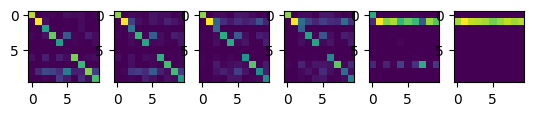

In [36]:
# draw confussion matrix

fig, axs = plt.subplots(nrows=1, ncols=len(smoothings))
    
for i, ax in enumerate(axs.flat):
    
    ax.set_label(smoothings[i])

    ax.imshow(scores[i][0])

In [37]:
# Accuracy

for i in range(len(scores)):
    print(f'Smoothing: {smoothings[i]} \tAccuracy: {scores[i][1]}')

Smoothing: 0.01 	Accuracy: 0.6949
Smoothing: 0.1 	Accuracy: 0.6764
Smoothing: 0.5 	Accuracy: 0.6406
Smoothing: 1.0 	Accuracy: 0.6072
Smoothing: 10 	Accuracy: 0.259
Smoothing: 100 	Accuracy: 0.1135


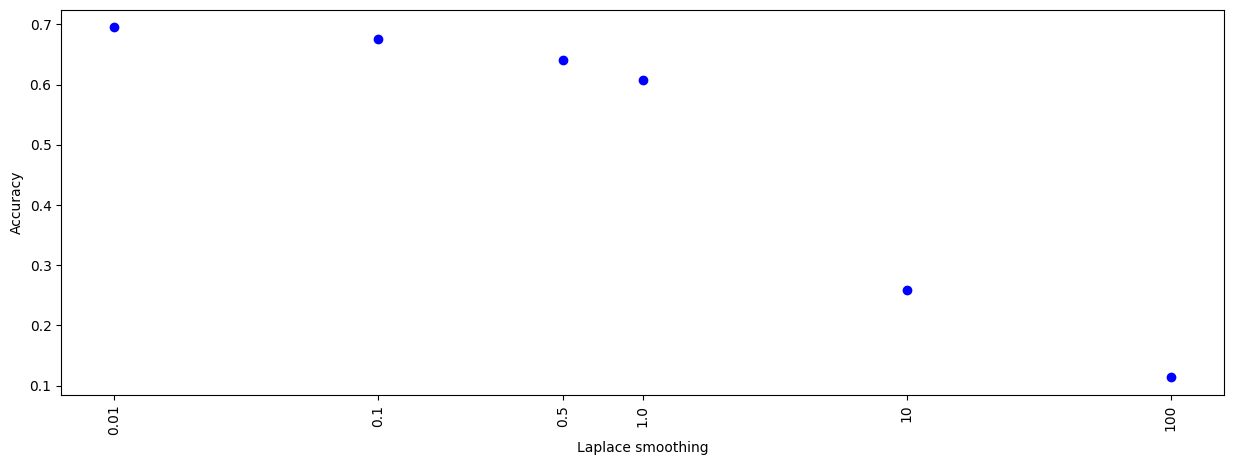

In [38]:
plt.rcParams["figure.figsize"] = (15,5)

plt.plot(list(map(math.log,smoothings)), [scores[i][1] for i in range(len(scores))], 'bo')
plt.xlabel('Laplace smoothing')
plt.ylabel('Accuracy')
plt.xticks(list(map(math.log,smoothings)), labels=smoothings, rotation=90)

plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]